<a href="https://colab.research.google.com/github/mayhd3/NSF-REU-2021/blob/main/AMImodels1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        1002   1003   1004   1005   1006  ...   7437   7438   7441   7442   7443
0      0.362  0.692  1.310  0.177  0.048  ...  0.256  0.023  0.289  0.584  0.148
1      0.064  0.381  1.142  0.172  0.086  ...  0.219  0.001  0.187  0.207  0.148
2      0.119  0.380  1.218  0.152  0.097  ...  0.304  0.025  0.120  0.196  0.134
3      0.023  0.379  0.903  0.158  0.045  ...  0.238  0.015  0.103  0.196  0.167
4      0.140  0.346  0.790  0.159  0.056  ...  0.284  0.010  0.104  0.199  0.107
...      ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
25723  0.079  0.850  1.494  0.950  1.221  ...  0.500  0.098  0.797  0.134  0.496
25724  0.132  0.786  1.612  0.507  1.174  ...  0.356  0.098  0.743  0.128  1.088
25725  0.084  0.898  1.819  0.634  1.155  ...  0.533  0.099  0.730  0.096  0.486
25726  0.116  0.802  1.422  0.455  1.131  ...  0.351  0.098  1.515  0.165  0.318
25727  0.147  0.835  1.393  0.604  1.176  ...  0.461  0.098  0.935  0.097  0.332

[25728 rows x 3639 columns]

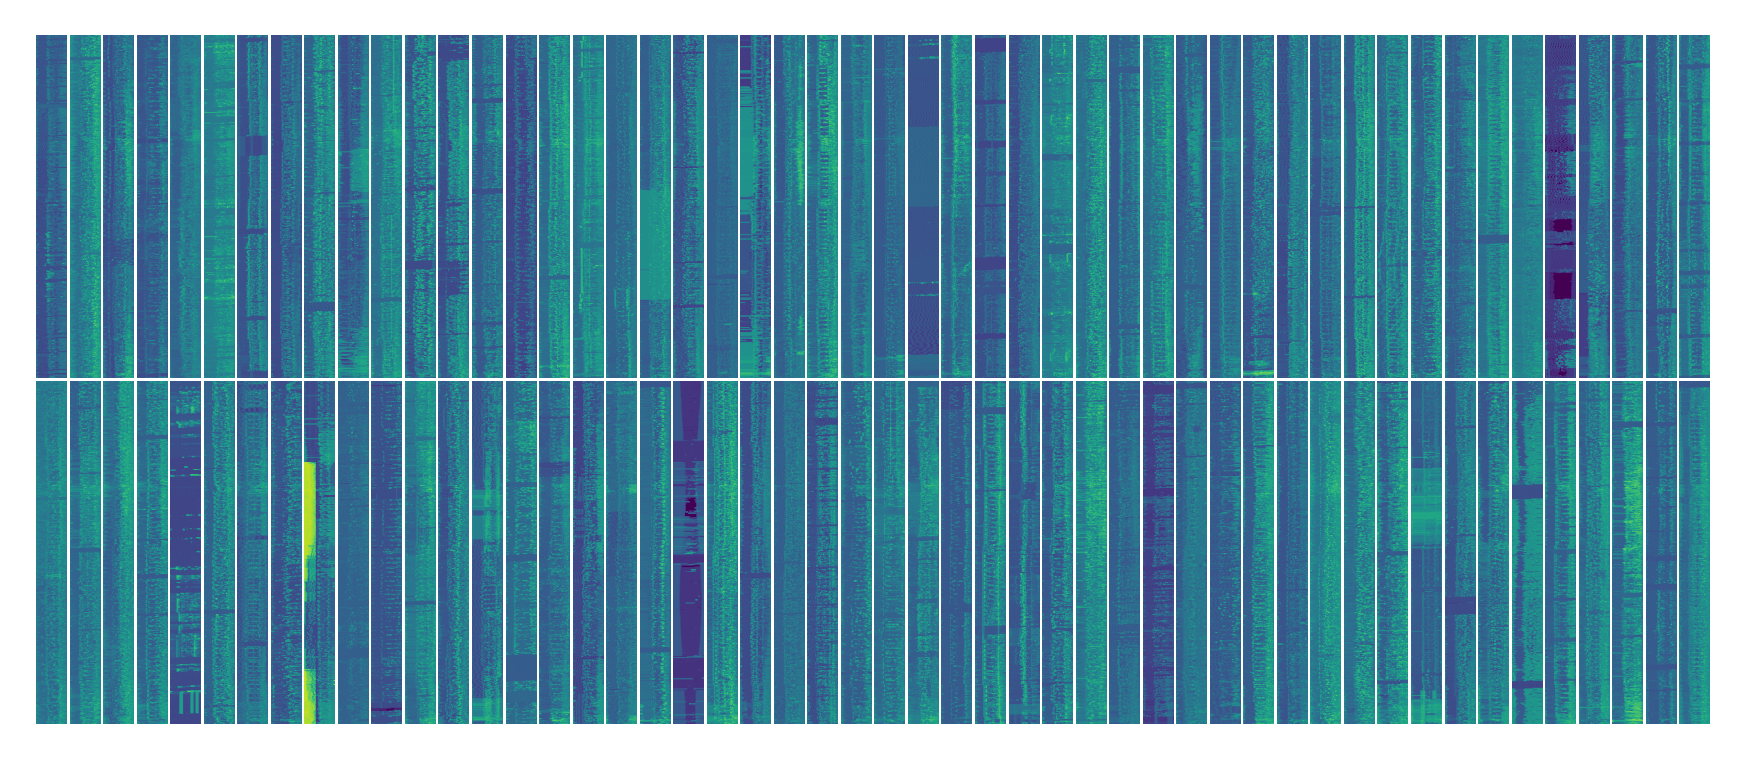

In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import PowerNorm

if not os.path.exists('Irish_dataset.csv'):
  !gdown --id 1OFQo6CmBPwn3FRB5EsRm9t6wba_5Lcr9

dataset = pd.read_csv('Irish_dataset.csv')
print(dataset)

samples = dataset.to_numpy().T.reshape((3639,-1,48))
shape = samples.shape
print(shape)

vmin,vmax = samples.min(),samples.max()
def heatmap(data):
  ig = ImageGrid(plt.gcf(), 111, nrows_ncols=(2, 50), axes_pad=2**-7, direction='column')
  for ax,im in zip(ig,data):
    ax.set_axis_off()
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.imshow(im, norm=PowerNorm(gamma=.25, vmin=vmin, vmax=vmax))

plt.figure(dpi=360)
heatmap(samples[:100])


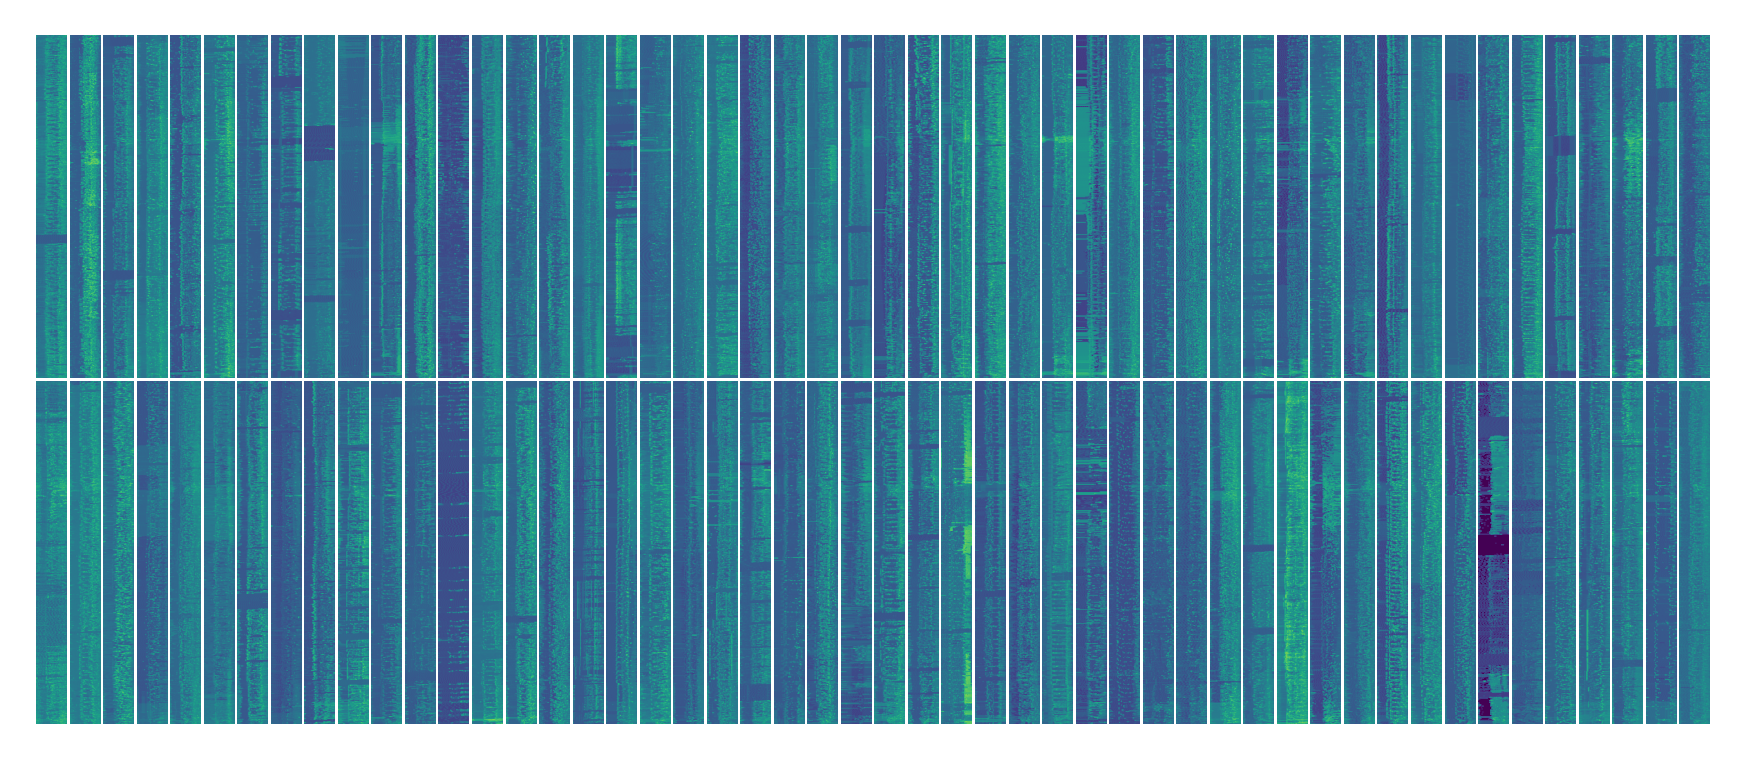

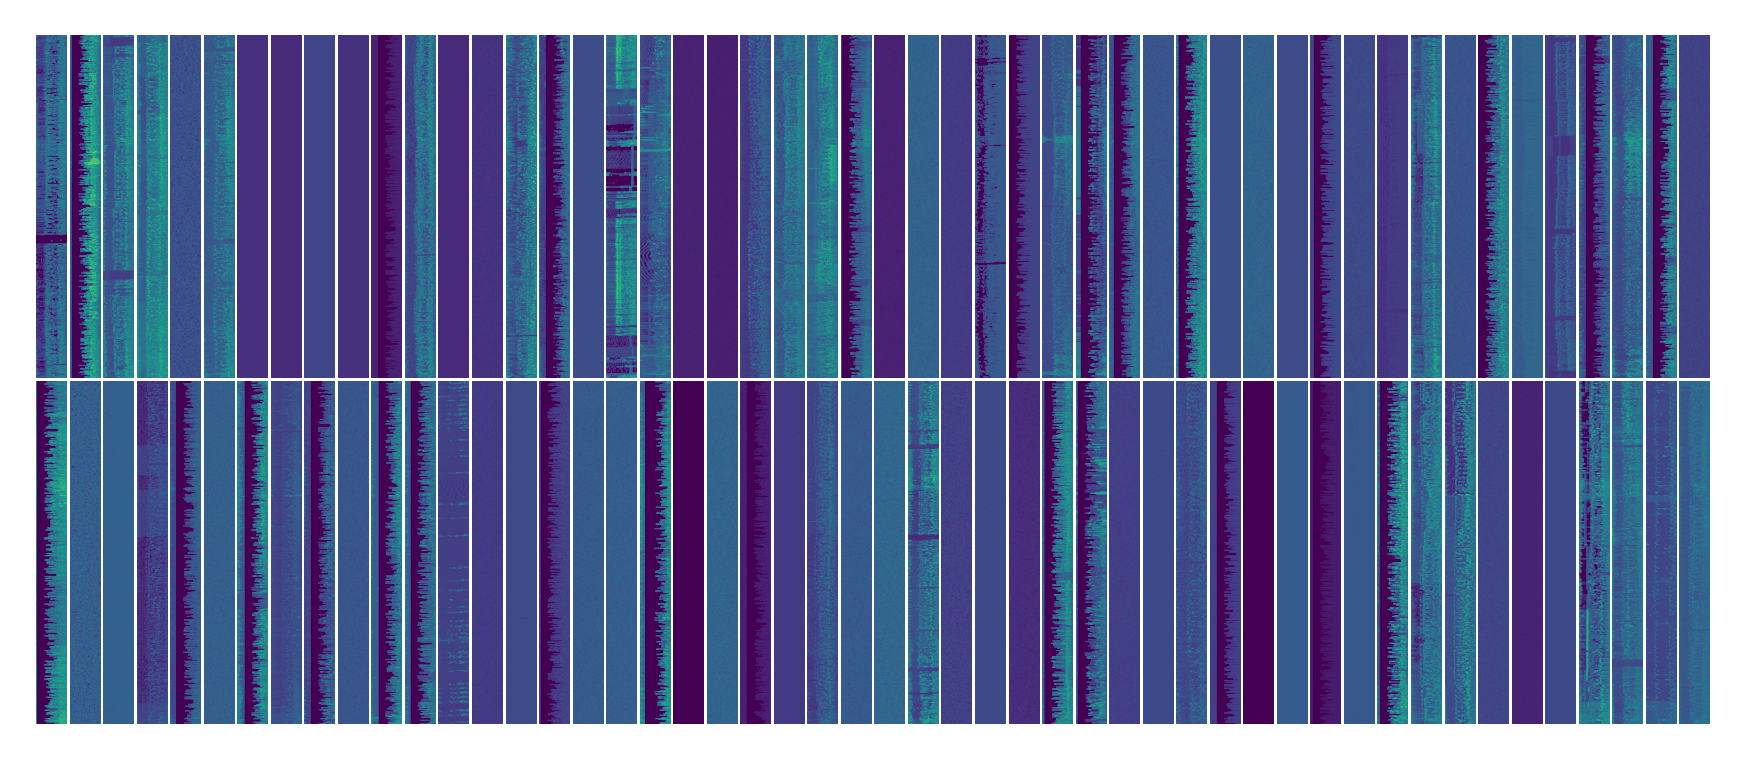

In [81]:
import random
import math

# random permutation of linear space
def rpls(k,n):
  return np.random.permutation(np.linspace(0,k,num=n,endpoint=False,dtype=int))


FDI = [ # A Tunable Fraud Detection System for Advanced Metering Infrastructure Using Short-Lived Patterns, Table I
  lambda X: np.dot(random.uniform(.1,.6),X),
  lambda X: np.clip(X,None,random.uniform(.1,.6)*np.median(X)),
  lambda X: np.maximum(X - random.uniform(.1,.6)*np.median(X), np.zeros_like(X)),
  lambda X: np.where( # sic/tf - tf/ti - tf/
    np.roll(
      np.tile(np.arange(X.shape[1]),(X.shape[0],1)) < \
      np.random.randint(X.shape[1]*1//4, X.shape[1]*3//4, X.shape[0]).reshape(X.shape[0],1),
      np.random.randint(0,X.shape[1]*1//4)
    ),
    np.zeros_like(X),
    X
  ),
  lambda X: np.multiply(np.random.uniform(low=.1,high=.6,size=X.shape),X),
  lambda X: np.dot(np.mean(X),np.random.uniform(low=.1,high=.6,size=X.shape)),
]

baddata = samples.copy()
# random subset of indices
def rsoi(k,n):
  return np.random.choice(np.arange(k), size=n, replace=False)

thieves = rsoi(samples.shape[0], 100)
for thief in thieves:
  baddata[thief] = FDI[thief%len(FDI)](samples[thief])
  for extra in rsoi(len(FDI), int(min(len(FDI),-math.log2(random.random())))):
    baddata[thief] = FDI[extra](baddata[thief])

#thieves = (rpls(s,len(samples)//8) for s in shape)
#for atk, (idx, row, col) in enumerate(zip(*thieves)):
#  start = np.ravel_multi_index((row,col),samples[idx].shape)
#  baddata[idx].flat[start:] = attacks[atk](samples[idx].flat[start:])

#for benign, malign in zip(samples,baddata):
#  assert malign.sum() <= benign.sum()

plt.figure(dpi=360)
heatmap(samples[thieves])

plt.figure(dpi=360)
heatmap(baddata[thieves])

(195046, 48)
9362208


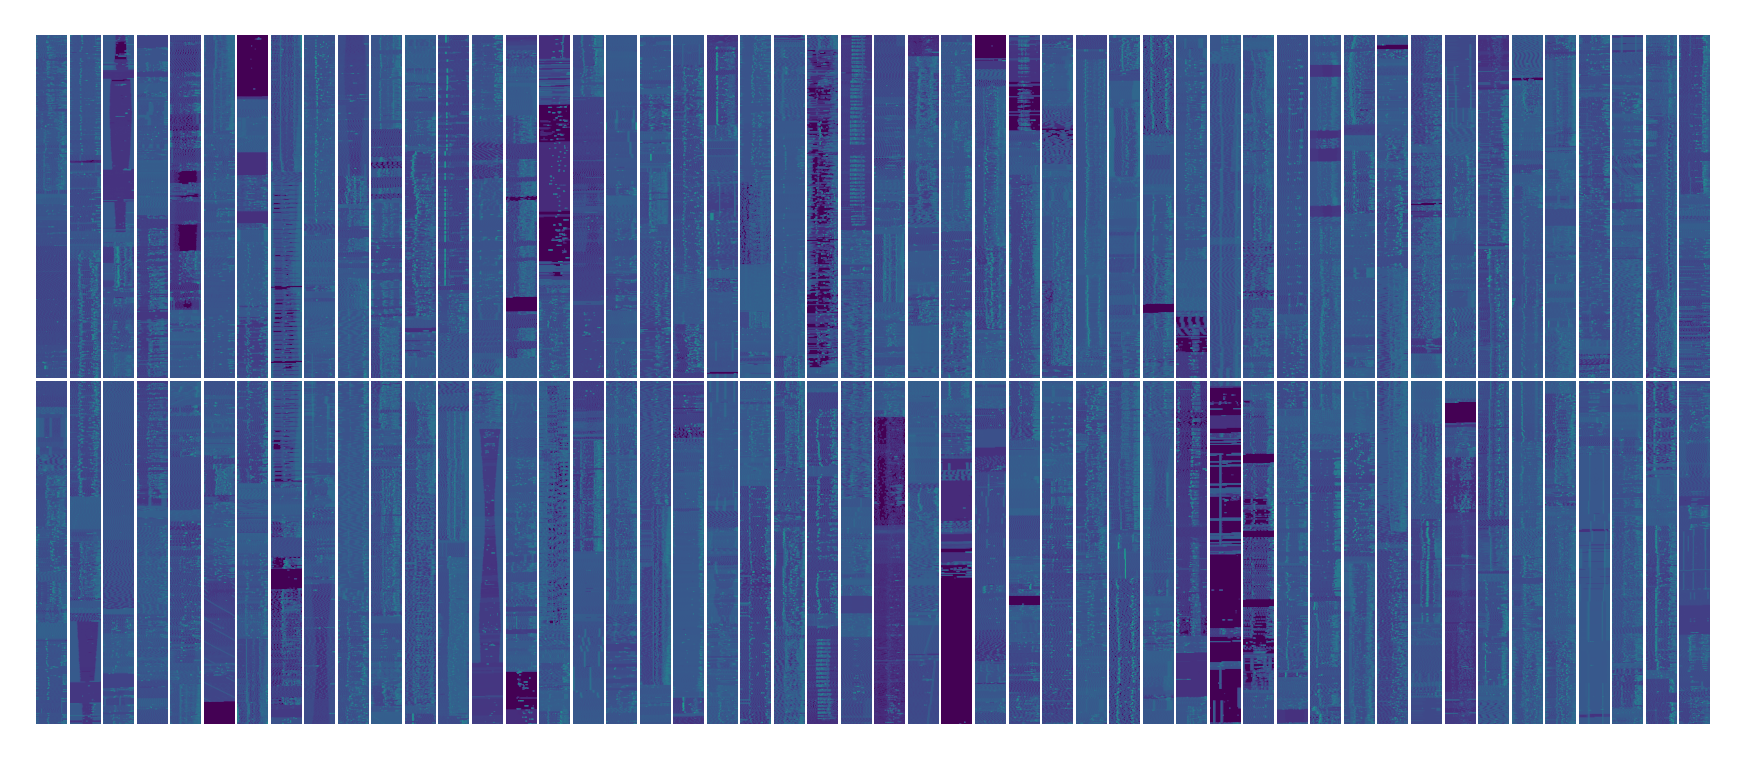

In [80]:
days_total = samples.sum(axis=2)
tenth_percentile = np.percentile(days_total, 10)
bottom_ten = samples[days_total < tenth_percentile]
bottom_ten_train = bottom_ten.reshape((-1, samples.shape[2]))
print(bottom_ten_train.shape)
print(bottom_ten_train.size)
plt.figure(dpi=360)
heatmap(bottom_ten[:536*100].reshape(-1,536,48))